# Introduction

This notebook will go through the steps to undertake a classification using a segmentation rather than a pixel based classification.

A number of studies have proposed that segmenting an image and classifying the segments can produce a better classification result than classifying individual pixels.

The notebook will go through the following steps:

Perform segmentation
Populate segments with data
Extract sample data
Split sample data into training, testing and validation sets
Training Classifier
Apply Classifier
Running Notebook
The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense.

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

### Jupyter-lab:

> Edit > 'Clear All Outputs'

### Jupyter-notebook:

> Cell > 'All Outputs' > Clear

### Fuente: 

Código adaptado de RSGISLib Tutorials
Repositorio: https://github.com/remotesensinginfo/rsgislib-tutorials
Segmentación: https://github.com/remotesensinginfo/rsgislib-tutorials/blob/main/03_intro_image_classification/02_segment_ml_classification.ipynb

In [1]:
# Import modules from python standard library
import os
import pprint
import random

# Import the matplotlib plotting module and set it to work within
# a notebook environment.

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.classification
import rsgislib.classification.classratutils
import rsgislib.classification.classsklearn
import rsgislib.rastergis
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.vectorutils
import rsgislib.vectorutils.createrasters
import rsgislib.zonalstats
from rsgislib.segmentation import shepherdseg
from sklearn.ensemble import RandomForestClassifier

# Import the geopandas module
os.environ["USE_PYGEOS"] = "0"
import geopandas

# Import the numpy module
import numpy

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

Image Data Size: 10470 x 9481


/Users/felipehernandez/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


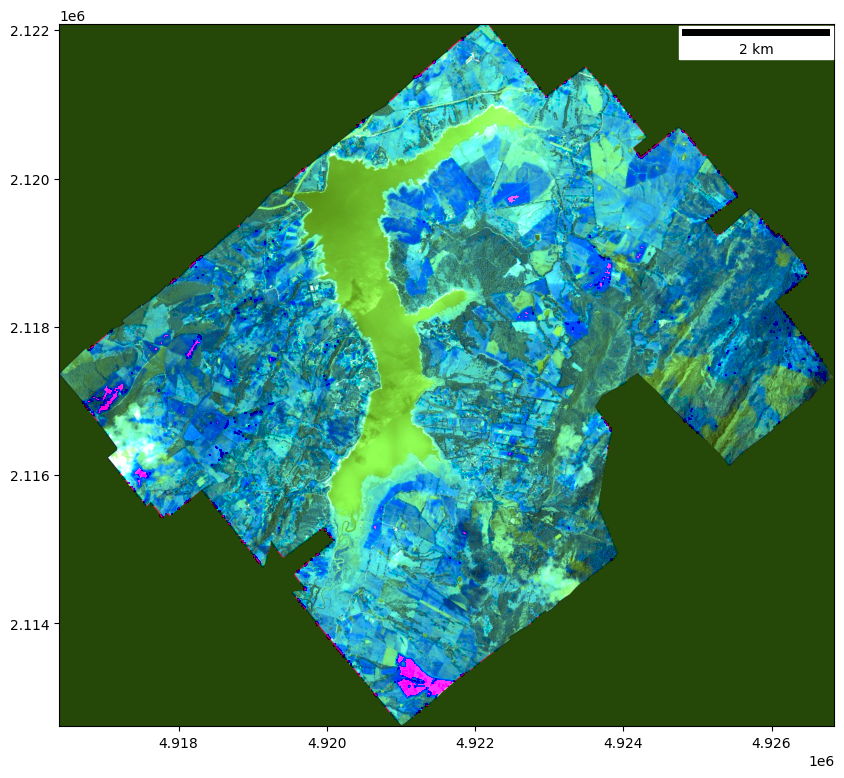

In [2]:
input_img = "/Users/felipehernandez/Documents/Natalia/Desarrollo/Repos/data/fusion_satelite_avion/processed_images/Resultado mosaico 1m/ihs/RGB832/IHS_ultracam_1_2020_10_RGB832.tif"

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image data using bands 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]

rsgislib.tools.mapping.create_raster_img_map(ax, 
                                             input_img, 
                                             img_bands=[3, 2, 1], 
                                             img_stch=rsgislib.IMG_STRETCH_STDEV)

In [3]:
out_clumps_img = "IHS_ultracam_1_2020_10_RGB832_segs.kea"
out_mean_img = "IHS_ultracam_1_2020_10_RGB832_meanimg.kea"
tmp_dir = "tmp"

shepherdseg.run_shepherd_segmentation(
    input_img,
    out_clumps_img,
    out_mean_img,
    tmp_dir,
    gdalformat="KEA",  # Output file format
    calc_stats=True,  # Calculate statistics on the output images
    no_stretch=False,  # Normalise the input bands by applying a 2 standard devation stretch
    no_delete=False,  # Delete the temporary files created during the processing
    num_clusters=60,  # The number of clusters (k) for the initial kMeans clustering
    min_n_pxls=100,  # Minimum number of pixels within a clump (segment)
    dist_thres=100,
    bands=[3, 2, 1],  # Just use bands 8 (NIR), 9 (SWIR) and 3 (Red)
    sampling=100,  # Speed up the kMeans clustering by only using every 100th pixel.
    km_max_iter=200,  # Maximum number of kMeans iterations
    process_in_mem=True,  # Do the process using in-memory datasets rather than to disk
    save_process_stats=False,
    img_stretch_stats="",
    kmeans_centres="",
    img_stats_json_file="",
)

Subsetting the image bands
New image width = 10470 height = 9481 bands = 3

Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.


Band[1] Min = 0 Mean = 19.1296396356 (Std Dev = 28.7900707238) max = 255
Band[2] Min = 0 Mean = 18.9924993064 (Std Dev = 10.6227964406) max = 255
Band[3] Min = 10 Mean = 32.8227601133 (Std Dev = 23.733059099) max = 185
New image width = 10470 height = 9481 bands = 3

New image width = 10470 height = 9481 bands = 3

Image: tmp/IHS_ultracam_1_2020_10_RGB832_bselect.kea
	 Variable 'b1' is band 1
New image width = 10470 height = 9481 bands = 1

Mask stretched Image.
New image width = 10470 height = 9481 bands = 3

Deleting file: tmp/IHS_ultracam_1_2020_10_RGB832_stchdonly.kea
Deleting file: tmp/IHS_ultracam_1_2020_10_RGB832_stchdonly_off.kea
Deleting file: tmp/IHS_ultracam_1_2020_10_RGB832_stchdmaskonly.kea
Performing KMeans.
inputImage = tmp/IHS_ultracam_1_2020_10_RGB832_stchd.ke

In [5]:
import rsgislib.vectorutils.createvectors

segs_vec_file = "IHS_ultracam_1_2020_10_RGB832_segs.gpkg"
segs_vec_lyr = "IHS_ultracam_1_2020_10_RGB832_segs"

rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file=segs_vec_file,  # The output vector file name and path
    out_vec_lyr=segs_vec_lyr,  # The output vector layer name
    out_format="GPKG",  # The output vector format
    input_img=out_clumps_img,  # The input segmentation image
    img_band=1,  # The band within the input image
    mask_img=out_clumps_img,  # A mask image (usually the same as the input image)
    mask_band=1,  # The band within the mask image
)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Polygonising...


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  3.82it/s]

Completed


101it [02:13,  1.32s/it]                                                        


In [6]:
bs = []
bs.append(rsgislib.rastergis.BandAttStats(band=1, mean_field="blue_refl"))
bs.append(rsgislib.rastergis.BandAttStats(band=2, mean_field="green_refl"))
bs.append(rsgislib.rastergis.BandAttStats(band=3, mean_field="nir_b8_refl"))
rsgislib.rastergis.populate_rat_with_stats(input_img, out_clumps_img, bs)

In [7]:
# Create Training Rasterise tmp directory
tmp_train_dir = "train_tmp"
if not os.path.exists(tmp_train_dir):
    os.mkdir(tmp_train_dir)

vec_train_file = "/Users/felipehernandez/Documents/entrenamiento_1.gpkg"

# Define Training Data
class_vec_sample_clumps_info = list()

# Define the file name of the samples HDF5 file, which will be created
tuberculos_clumps_h5 = "tuberculos_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="tuberculos",
        vec_file=vec_train_file,
        vec_lyr="tuberculos",
        file_h5=tuberculos_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
pastos_limpios_clumps_h5 = "pastos_limpios_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="pastos_limpios",
        vec_file=vec_train_file,
        vec_lyr="pastos_limpios",
        file_h5=pastos_limpios_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
pastos_enmalezados_clumps_h5 = "pastos_enmalezados_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="pastos_enmalezados",
        vec_file=vec_train_file,
        vec_lyr="pastos_enmalezados",
        file_h5=pastos_enmalezados_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
agricolas_heterogeneas_clumps_h5 = "agricolas_heterogeneas_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="agricolas_heterogeneas",
        vec_file=vec_train_file,
        vec_lyr="agricolas_heterogeneas",
        file_h5=agricolas_heterogeneas_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
bosque_abierto_clumps_h5 = "bosque_abierto_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="bosque_abierto",
        vec_file=vec_train_file,
        vec_lyr="bosque_abierto",
        file_h5=bosque_abierto_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
bosque_fragmentado_clumps_h5 = "bosque_fragmentado_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=6,
        class_name="bosque_fragmentado",
        vec_file=vec_train_file,
        vec_lyr="bosque_fragmentado",
        file_h5=bosque_fragmentado_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
plantacion_forestal_clumps_h5 = "plantacion_forestal_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=7,
        class_name="plantacion_forestal",
        vec_file=vec_train_file,
        vec_lyr="plantacion_forestal",
        file_h5=plantacion_forestal_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
arbustal_clumps_h5 = "arbustal_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=8,
        class_name="arbustal",
        vec_file=vec_train_file,
        vec_lyr="arbustal",
        file_h5=arbustal_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
herbazal_clumps_h5 = "herbazal_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=9,
        class_name="herbazal",
        vec_file=vec_train_file,
        vec_lyr="herbazal",
        file_h5=herbazal_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
vegetacion_secundaria_clumps_h5 = "vegetacion_secundaria_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=10,
        class_name="vegetacion_secundaria",
        vec_file=vec_train_file,
        vec_lyr="vegetacion_secundaria",
        file_h5=vegetacion_secundaria_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
lagunas_lagos_cienagas_naturales_clumps_h5 = "lagunas_lagos_cienagas_naturales_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=11,
        class_name="lagunas_lagos_cienagas",
        vec_file=vec_train_file,
        vec_lyr="lagunas_lagos_cienagas",
        file_h5=lagunas_lagos_cienagas_naturales_clumps_h5,
    )
)

rsgislib.classification.classratutils.populate_clumps_with_class_training(
    out_clumps_img,
    class_vec_sample_clumps_info,
    tmp_train_dir,
    classes_int_col="class_int_smpls",
    classes_name_col="class_name_smpls",
)


Creating output image using input image
Writing Stats (Mean, ) to Output RAT

Running Rasterise now...
Creating output image using input image
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and C

In [8]:
# Columns to be extracted and used for classification
cols = [
    "blue_refl",
    "green_refl",
    "nir_b8_refl"
]

# Reading classification column from RAT.
class_int_smpls_col = rsgislib.rastergis.get_column_data(out_clumps_img, "class_int_smpls")
# Get the unique classes (i.e., there are samples for the class)
unq_classes = numpy.unique(class_int_smpls_col)

cls_smpls_clumps_info = dict()

# Loop through each of the classes to extract the samples to a HDF5
for class_vec_sample in class_vec_sample_clumps_info:
    print("{}:".format(class_vec_sample.class_name))
    # Check the class is within the list of unique classes
    if class_vec_sample.id in unq_classes:
        # Extract the class samples to a HDF5 file
        rsgislib.classification.classratutils.extract_rat_col_data(
            out_clumps_img,
            cols,
            "class_int_smpls",
            class_vec_sample.id,
            class_vec_sample.file_h5,
            datatype=rsgislib.TYPE_32FLOAT,
        )
        cls_smpls_clumps_info[
            class_vec_sample.class_name
        ] = rsgislib.classification.ClassSimpleInfoObj(
            id=class_vec_sample.id, file_h5=class_vec_sample.file_h5
        )

tuberculos:
n feats: 50
n cols: 3
pastos_limpios:
n feats: 102
n cols: 3
pastos_enmalezados:
n feats: 46
n cols: 3
agricolas_heterogeneas:
n feats: 296
n cols: 3
bosque_abierto:
n feats: 16
n cols: 3
bosque_fragmentado:
n feats: 6
n cols: 3
plantacion_forestal:
n feats: 55
n cols: 3
arbustal:
n feats: 226
n cols: 3
herbazal:
n feats: 11
n cols: 3
vegetacion_secundaria:
n feats: 80
n cols: 3
lagunas_lagos_cienagas:
n feats: 13
n cols: 3


In [10]:
class_vec_sample_pixels_info = list()

# Define the file name of the samples HDF5 file, which will be created
tuberculos_pixels_h5 = "tuberculos_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="tuberculos",
        vec_file=vec_train_file,
        vec_lyr="tuberculos",
        file_h5=tuberculos_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
pastos_limpios_pixels_h5 = "pastos_limpios_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="pastos_limpios",
        vec_file=vec_train_file,
        vec_lyr="pastos_limpios",
        file_h5=pastos_limpios_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
pastos_enmalezados_pixels_h5 = "pastos_enmalezados_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="pastos_enmalezados",
        vec_file=vec_train_file,
        vec_lyr="pastos_enmalezados",
        file_h5=pastos_enmalezados_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
agricolas_heterogeneas_pixels_h5 = "agricolas_heterogeneas_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="agricolas_heterogeneas",
        vec_file=vec_train_file,
        vec_lyr="agricolas_heterogeneas",
        file_h5=agricolas_heterogeneas_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
bosque_abierto_pixels_h5 = "bosque_abierto_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="bosque_abierto",
        vec_file=vec_train_file,
        vec_lyr="bosque_abierto",
        file_h5=bosque_abierto_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
bosque_fragmentado_pixels_h5 = "bosque_fragmentado_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=6,
        class_name="bosque_fragmentado",
        vec_file=vec_train_file,
        vec_lyr="bosque_fragmentado",
        file_h5=bosque_fragmentado_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
plantacion_forestal_pixels_h5 = "plantacion_forestal_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=7,
        class_name="plantacion_forestal",
        vec_file=vec_train_file,
        vec_lyr="plantacion_forestal",
        file_h5=plantacion_forestal_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
arbustal_pixels_h5 = "arbustal_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=8,
        class_name="arbustal",
        vec_file=vec_train_file,
        vec_lyr="arbustal",
        file_h5=arbustal_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
herbazal_pixels_h5 = "herbazal_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=9,
        class_name="herbazal",
        vec_file=vec_train_file,
        vec_lyr="herbazal",
        file_h5=herbazal_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
vegetacion_secundaria_pixels_h5 = "vegetacion_secundaria_smpls_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=10,
        class_name="vegetacion_secundaria",
        vec_file=vec_train_file,
        vec_lyr="vegetacion_secundaria",
        file_h5=vegetacion_secundaria_pixels_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
lagunas_lagos_cienagas_naturales_pixels_h5 = "lagunas_lagos_cienagas_naturales_pixels.h5"
class_vec_sample_pixels_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=11,
        class_name="lagunas_lagos_cienagas",
        vec_file=vec_train_file,
        vec_lyr="lagunas_lagos_cienagas",
        file_h5=lagunas_lagos_cienagas_naturales_pixels_h5,
    )
)

img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3]
    )
)

cls_smpls_pixel_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_pixels_info, tmp_train_dir, ref_img=input_img
)

Creating output image using input image
Writing Stats to RAT

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.





Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.





Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.





Running Rasterise now...
Creating output image using input imageGet Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.






Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Creating output ima

In [11]:
print("Number of Samples:")
cls_smpls_info = dict()
for class_name in cls_smpls_pixel_info:
    h5_files = [cls_smpls_pixel_info[class_name].file_h5]
    if class_name in cls_smpls_clumps_info:
        h5_files.append(cls_smpls_clumps_info[class_name].file_h5)

    out_file_h5 = cls_smpls_pixel_info[class_name].file_h5.replace("_pixels", "")
    rsgislib.zonalstats.merge_extracted_hdf5_data(
        h5_files, out_file_h5, datatype=rsgislib.TYPE_32FLOAT
    )
    cls_smpls_info[class_name] = rsgislib.classification.ClassSimpleInfoObj(
        id=cls_smpls_pixel_info[class_name].id,
        file_h5=out_file_h5,
        blue=cls_smpls_pixel_info[class_name].blue,
        green=cls_smpls_pixel_info[class_name].green,
        red=cls_smpls_pixel_info[class_name].red,
    )

    print(
        "\t{}: {}".format(
            class_name, rsgislib.classification.get_num_samples(out_file_h5)
        )
    )

Number of Samples:
	tuberculos: 123
	pastos_limpios: 251
	pastos_enmalezados: 96
	agricolas_heterogeneas: 734
	bosque_abierto: 41
	bosque_fragmentado: 14
	plantacion_forestal: 180
	arbustal: 617
	herbazal: 61
	vegetacion_secundaria: 205
	lagunas_lagos_cienagas: 38


In [13]:
cls_smpls_info["tuberculos"].red = 59
cls_smpls_info["tuberculos"].green = 81
cls_smpls_info["tuberculos"].blue = 16

cls_smpls_info["pastos_limpios"].red = 190
cls_smpls_info["pastos_limpios"].green = 192
cls_smpls_info["pastos_limpios"].blue = 146

cls_smpls_info["pastos_enmalezados"].red = 119
cls_smpls_info["pastos_enmalezados"].green = 140
cls_smpls_info["pastos_enmalezados"].blue = 67

cls_smpls_info["agricolas_heterogeneas"].red = 44
cls_smpls_info["agricolas_heterogeneas"].green = 168
cls_smpls_info["agricolas_heterogeneas"].blue = 128

cls_smpls_info["bosque_abierto"].red = 130
cls_smpls_info["bosque_abierto"].green = 211
cls_smpls_info["bosque_abierto"].blue = 123

cls_smpls_info["bosque_fragmentado"].red = 65
cls_smpls_info["bosque_fragmentado"].green = 146
cls_smpls_info["bosque_fragmentado"].blue = 64

cls_smpls_info["plantacion_forestal"].red = 97
cls_smpls_info["plantacion_forestal"].green = 178
cls_smpls_info["plantacion_forestal"].blue = 93

cls_smpls_info["arbustal"].red = 137
cls_smpls_info["arbustal"].green = 214
cls_smpls_info["arbustal"].blue = 49

cls_smpls_info["herbazal"].red = 147
cls_smpls_info["herbazal"].green = 160
cls_smpls_info["herbazal"].blue = 26

cls_smpls_info["vegetacion_secundaria"].red = 169
cls_smpls_info["vegetacion_secundaria"].green = 225
cls_smpls_info["vegetacion_secundaria"].blue = 89

cls_smpls_info["lagunas_lagos_cienagas"].red = 109
cls_smpls_info["lagunas_lagos_cienagas"].green = 219
cls_smpls_info["lagunas_lagos_cienagas"].blue = 215

In [28]:
smpls_dir = "cls_smpls"
if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)

cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, smpls_dir
)

# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 5, 5, 6
)

0=1: (Train:cls_smpls/tuberculos_smpls_train.h5, Test:cls_smpls/tuberculos_smpls_test.h5, Valid:cls_smpls/tuberculos_smpls_valid.h5), (59, 81, 16)
1=2: (Train:cls_smpls/pastos_limpios_smpls_train.h5, Test:cls_smpls/pastos_limpios_smpls_test.h5, Valid:cls_smpls/pastos_limpios_smpls_valid.h5), (190, 192, 146)
2=3: (Train:cls_smpls/pastos_enmalezados_smpls_train.h5, Test:cls_smpls/pastos_enmalezados_smpls_test.h5, Valid:cls_smpls/pastos_enmalezados_smpls_valid.h5), (119, 140, 67)
3=4: (Train:cls_smpls/agricolas_heterogeneas_smpls_train.h5, Test:cls_smpls/agricolas_heterogeneas_smpls_test.h5, Valid:cls_smpls/agricolas_heterogeneas_smpls_valid.h5), (44, 168, 128)
4=5: (Train:cls_smpls/bosque_abierto_smpls_train.h5, Test:cls_smpls/bosque_abierto_smpls_test.h5, Valid:cls_smpls/bosque_abierto_smpls_valid.h5), (130, 211, 123)
5=6: (Train:cls_smpls/bosque_fragmentado_smpls_train.h5, Test:cls_smpls/bosque_fragmentado_smpls_test.h5, Valid:cls_smpls/bosque_fragmentado_smpls_valid.h5), (65, 146, 64)

In [29]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100],
        "max_depth": [4, 8, 10, 12],
    },
)

sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)

Training data size: 56 x 3
Best score was 0.4303030303030303 and has parameters {'max_depth': 10, 'n_estimators': 50}.


In [30]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 68 x 3
Testing data size: 55 x 3
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 94.12%
Classifier Test Score = 29.09%


(0.9411764705882353, 0.2909090909090909)

In [31]:
rsgislib.classification.classsklearn.apply_sklearn_classifier_rat(
    out_clumps_img,
    cols,
    sk_classifier,
    cls_smpls_fnl_info,
    out_col_int="class_id",
    out_col_str="class_names",
)

In [32]:
out_cls_img = "ultracam_1_2020_10_RGB832_clumps_cls_rslt.kea"

rsgislib.classification.collapse_classes(
    out_clumps_img,
    out_cls_img,
    gdalformat="KEA",
    class_col="class_names",
    class_int_col="class_id",
)

Opening an image
Find the class names...

4:	 agricolas_heterogeneas: [44,168,128]
8:	 arbustal: [137,214,49]
5:	 bosque_abierto: [130,211,123]
6:	 bosque_fragmentado: [65,146,64]
9:	 herbazal: [147,160,26]
11:	 lagunas_lagos_cienagas: [109,219,215]
3:	 pastos_enmalezados: [119,140,67]
2:	 pastos_limpios: [190,192,146]
7:	 plantacion_forestal: [97,178,93]
1:	 tuberculos: [59,81,16]
10:	 vegetacion_secundaria: [169,225,89]
Started .0..10..20..30..40..50..60..70..80..90..100..Completed
New image width = 10470 height = 9481 bands = 1



Image Data Size: 10470 x 9481


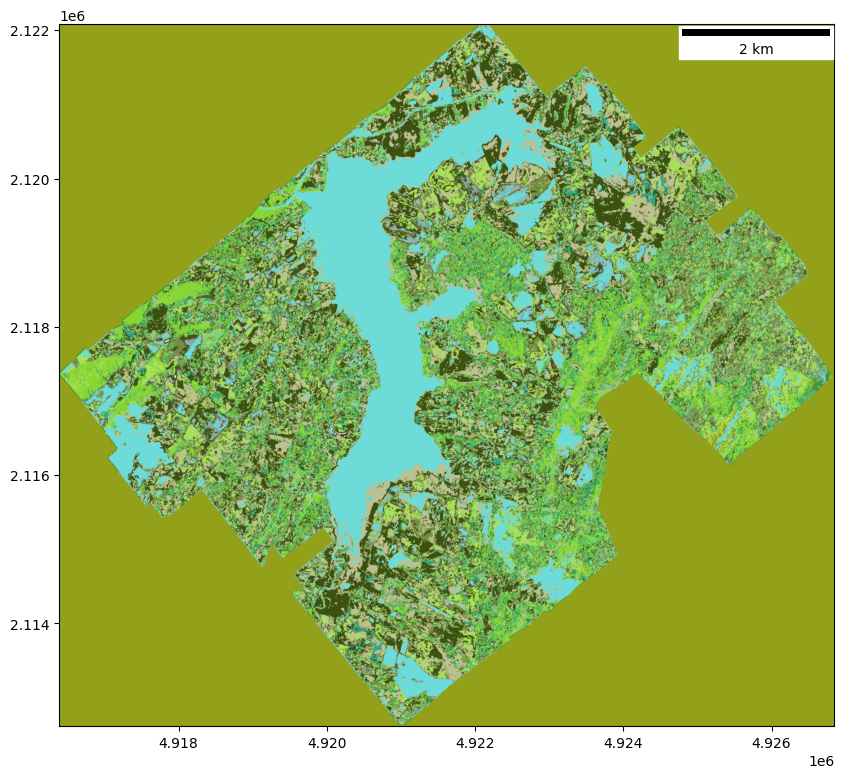

In [33]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

rsgislib.tools.mapping.create_thematic_raster_map(ax, out_cls_img)

In [34]:
cls_info = rsgislib.tools.plotting.create_legend_info_dict(
    out_cls_img,
    cls_names_col="class_names",
    use_title_case=True,
    underscore_to_space=True,
)


In [35]:
out_cls_img_1 = "ultracam_1_2020_10_RGB832_clumps_cls_rslt.tif"

rsgislib.classification.collapse_classes(
    out_clumps_img,
    out_cls_img_1,
    gdalformat="GTiff",
    class_col="class_names",
    class_int_col="class_id",
)

Opening an image
Find the class names...

4:	 agricolas_heterogeneas: [44,168,128]
8:	 arbustal: [137,214,49]
5:	 bosque_abierto: [130,211,123]
6:	 bosque_fragmentado: [65,146,64]
9:	 herbazal: [147,160,26]
11:	 lagunas_lagos_cienagas: [109,219,215]
3:	 pastos_enmalezados: [119,140,67]
2:	 pastos_limpios: [190,192,146]
7:	 plantacion_forestal: [97,178,93]
1:	 tuberculos: [59,81,16]
10:	 vegetacion_secundaria: [169,225,89]
Started .0..10..20..30..40..50..60..70..80..90..100..Completed
New image width = 10470 height = 9481 bands = 1



Image Data Size: 10470 x 9481
Image Data Size: 10470 x 9481
Max. characters in class name: 22
Column width: 144
Image: 300 x  154


/Users/felipehernandez/anaconda3/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


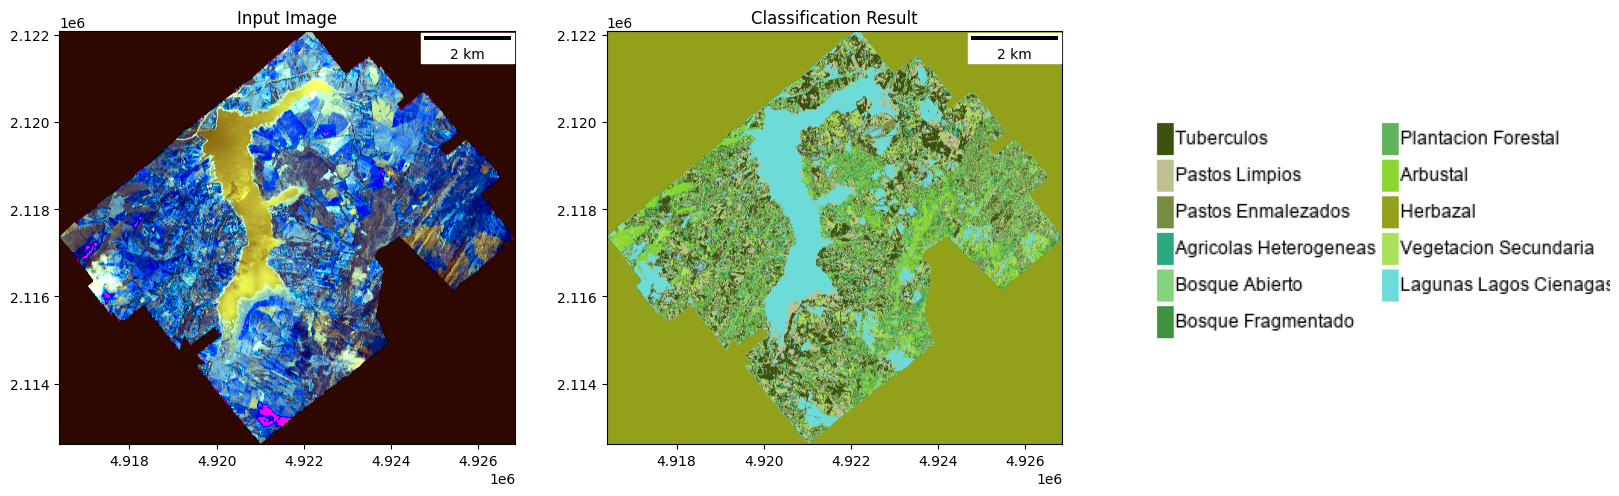

In [36]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [4915000, 4930000, 2112000, 2123000]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
# Add the Sentinel-2 image to the axis
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[3, 2, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.title.set_text("Input Image")

# Add the classification to the second axis.
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img, bbox=sub_img_bbox)
ax2.title.set_text("Classification Result")

rsgislib.tools.plotting.create_legend_img_mpl_ax(ax3, legend_info=cls_info, n_cols=2)

In [37]:
import rsgislib.vectorutils.createvectors

segs_vec_file_1 = "IHS_ultracam_1_2020_10_RGB832_class.gpkg"
segs_vec_lyr_1 = "IHS_ultracam_1_2020_10_RGB832_class"

rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file=segs_vec_file_1,  # The output vector file name and path
    out_vec_lyr=segs_vec_lyr_1,  # The output vector layer name
    out_format="GPKG",  # The output vector format
    input_img=out_cls_img,  # The input segmentation image
    img_band=1,  # The band within the input image
    mask_img=out_cls_img,  # A mask image (usually the same as the input image)
    mask_band=1,  # The band within the mask image
)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Polygonising...


100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  5.48it/s]

Completed


101it [01:23,  1.20it/s]                                                        
